# Identication of putative contaminant taxa

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(foreach)
require(tidyverse)
require(ggplot2)
require(data.table)
require(doParallel)
require(compositions)
require(VennDiagram)
registerDoParallel(cores=6)

Loading required package: foreach

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: doPara

### Data processing functions

In [2]:
load_data <- function(file_path) {
    df <- as.data.frame(fread(file_path)) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}


load_metadata <- function(file_path, df) {
    meta <- fread(file_path, na.strings=c("", NA))
    meta <- meta %>% 
        filter(npm_research_id %in% df$npm_research_id) %>%
        select(-removal_requested_by_supplier) %>%
        replace(is.na(.), "unknown")
    return(meta)
}


subset_metadata <- function(meta, n_subset) {
    meta <- as.data.frame(meta)
    cohorts <- unique(meta$site_supplying_sample)
    subset_vec <- c()

    for (i in cohorts) {
        ids <- meta$npm_research_id[meta$site_supplying_sample == i]
        
        if (length(ids) > n_subset) {
            subset_ids <- sample(ids, n_subset)
            subset_vec <- c(subset_vec, subset_ids)
        } else {
            subset_vec <- c(subset_vec, ids)
        }
    }

    meta_sub <- meta %>%
      filter(npm_research_id %in% subset_vec) 
    return(meta_sub)
}


retrieve_rows_from_meta <- function(df, meta) {
    return(df %>% filter(npm_research_id %in% meta$npm_research_id)) 
}


remove_cols <- function(df, col_to_exclude) {
    return(df %>% select(-all_of(col_to_exclude)))
}


remove_low_freq_taxa <- function(df, frac_presence) {
    n_original <- ncol(df[, colnames(df) != "npm_research_id"])
    PA_df <- apply(df[, 2:ncol(df)], 2, function(x) {ifelse(x > 0, T, F)})
    frac_df <- apply(PA_df, 2, function(x) {sum(x) / nrow(PA_df)})
    to_keep <- names(frac_df[frac_df > frac_presence])
    to_keep <- c("npm_research_id", to_keep)
    n_new <- length(to_keep) - 1
    print(str_glue("{n_new} / {n_original} taxa are present in {frac_presence} of samples"))
    return(df %>% select(all_of(to_keep)))
}


otu_to_RA <- function(df) {
    mat <- as.matrix(df[, colnames(df) != "npm_research_id"])
    RA_df <- as.data.frame(mat / rowSums(mat))
    RA_df <- add_column(RA_df, df$npm_research_id, .before = 1)
    colnames(RA_df)[1] <- "npm_research_id"
    
    return(RA_df)
}


get_meta_cols <- function(meta, meta_regex, to_exclude) {
    meta_cols <- colnames(meta)[grep(meta_regex, colnames(meta))]
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


otu_to_pa <- function(df, read_t) {
    pa_df <- as.matrix(df %>% select(-npm_research_id))
    pa_df[pa_df <= read_t] <- 0
    pa_df[pa_df > read_t] <- 1
    pa_df <- as_tibble(pa_df) %>% add_column(npm_research_id = df$npm_research_id, .before = 1)
    return(pa_df)
}


RA_to_clr <- function(df) {
    mat <- df[, colnames(df) != "npm_research_id"]
    clr_df <- clr(mat)
    return(cbind(data.frame(npm_research_id = df$npm_research_id), as.data.frame(clr_df, check.names = F)))
}


filter_taxa_by_presence <- function(prev_df, presence_t) {
    taxa_counts <- apply(prev_df %>% select(-npm_research_id), 2, sum)
    to_keep <- names(taxa_counts)[taxa_counts > presence_t]
    to_keep <- c("npm_research_id", to_keep)
    return(prev_df %>% select(all_of(to_keep)))
}

### Decontamination functions

In [3]:
filter_batch_levels <- function(dat, metadat, column) {
    # Remove levels with < x samples
    tmp <- tibble(data.frame(metadat)) %>%
            group_by(get(column)) %>%
            summarise(n = n())

    # Vector of group levels to keep
    to_keep <- tmp[tmp$n >= min_samples, "get(column)"]$`get(column)`
    to_keep <- to_keep[to_keep != "Unknown"]
    n_levels <- length(to_keep)

    if (n_levels < 2) {
        print(str_glue("After pruning, {column} has < 2 levels"))
    } else {
        print(str_glue("After pruning, {column} has {n_levels} levels"))
    }

    # Remove rows in metadata
    dat_meta <- dat %>%
        left_join(metadat, by = "npm_research_id") %>%
        filter(get(column) %in% to_keep)

    return(dat_meta)
}


get_taxon_diff_prev <- function(dat_meta, column, taxon) {
    prev_stats <- dat_meta %>%
        group_by_at(c(column)) %>%
        summarise(prevalence = sum(get(taxon)) / n())

    max_prev <- max(prev_stats$prevalence)
    min_prev <- min(prev_stats$prevalence)
    diff <- max_prev - min_prev
    max_level <- pull(prev_stats, column)[which(prev_stats$prevalence == max(prev_stats$prevalence))][1]
    min_level <- pull(prev_stats, column)[which(prev_stats$prevalence == min(prev_stats$prevalence))][1]

    crumb <- tibble(taxa = taxon, meta_col = column,
           max_level = max_level, min_level = min_level, 
           max_prev = max_prev, min_prev = min_prev,
           diff = diff)

    crumb <- distinct(crumb, taxa, .keep_all = T)

    return(crumb)
}

get_diff_prev <- function(dat, metadat, meta_cols, taxa_vec, read_threshold, prev_threshold, min_samples) {
    morsels <- foreach (column = meta_cols) %do% {
        dat_meta <- filter_batch_levels(dat, metadat, column)
        
        crumbs <- foreach (taxon = taxa_vec) %dopar% {
            get_taxon_diff_prev(dat_meta, column, taxon)
        }
        
        stopImplicitCluster()
        
        morsel <- bind_rows(crumbs)
        return(morsel)
    }

    result_df <- bind_rows(morsels)
    return(result_df)
}


preprocess_data <- function(df, meta_filt, read_threshold, presence_t) {
    # Filter data
    df_filt <- retrieve_rows_from_meta(df, meta_filt)
    df_filt2 <- remove_cols(df_filt, c(human, "unclassified"))
    prev_df <- otu_to_pa(df_filt2, read_threshold)
    prev_df <- filter_taxa_by_presence(prev_df, presence_t = presence_t) # Remove taxa that are not present in any samples
    
    return(prev_df)
}

decontaminate <- function(df, meta_filt, meta_cols, n, human, read_threshold, presence_t, min_samples, taxa_vec = NA) {
    # Preprocess df
    prev_df <- preprocess_data(df, meta_filt, read_threshold, presence_t)
    
    # Get list of taxa
    if (is.na(taxa_vec)) {
        taxa_vec <- colnames(prev_df)
        taxa_vec <- taxa_vec[taxa_vec != "npm_research_id"]
    }

    # Differential prevalence
    res <- get_diff_prev(prev_df, meta_filt, meta_cols, taxa_vec, read_threshold = read_threshold, min_samples = min_samples)

    return(res)
}

### Run decontamination

In [4]:
taxa_rank <- "S"
n <- 9999
human <- "Homo sapiens"
read_threshold <- 10
presence_t <- 0
min_samples <- 100

# Load data and remove low microbial read samples
to_retain <- fread("data/samples_above_95_reads.txt")$npm_research_id

df <- load_data(str_glue("data/temp_files_9999/07_abundance_matrix/abundance_matrix.subset_9999.{taxa_rank}.tsv")) %>% 
    filter(npm_research_id %in% to_retain)

meta <- load_metadata("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv", df) %>% 
    filter(npm_research_id %in% to_retain)

# Get metadata columns of interest
meta_cols <- get_meta_cols(meta, 
                           meta_regex = "kit|flow_cell", 
                           to_exclude = c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id"))

# Get metadata subset
meta_filt <- subset_metadata(meta, n)

# Run decontamination
# decon_raw <- decontaminate(df, meta, meta_cols, n, human, read_threshold, presence_t, min_samples)

In [5]:
# fwrite(decon_raw, str_glue("results/decontamination/diff_prev_V2/decon_V2_raw.read_t{read_threshold}.csv"))
decon_raw <- fread("results/decontamination/diff_prev_V2/decon_V2_raw.read_t10.csv")

### Find differential threshold

#### Query taxa that have overall prevalence > 0.2

In [6]:
prevalence_t <- 0.1
read_threshold <- 10
species_prev <- preprocess_data(df, meta, read_threshold, 0)
prev_stats <- apply(species_prev[, 2:ncol(species_prev)], 2, sum) / nrow(species_prev)
overall_prev <- data.frame(taxa = names(prev_stats), prevalence = as.vector(prev_stats))
prevalent_taxa <- overall_prev %>% filter(prevalence > prevalence_t)
prevalent_taxa <- prevalent_taxa$taxa
length(prevalent_taxa)

[1] 314

#### Positive and negative controls

In [14]:
pos_control

[1] "Acinetobacter lwoffii"         "Aerococcus viridans"          
 [3] "Bacillus thuringiensis"        "Bacillus pumilus"             
 [5] "Bacillus stratosphericus"      "Dietzia papillomatosis"       
 [7] "Moraxella osloensis"           "Planobacterium taklimakanense"
 [9] "Prolinoborus fasciculus"       "Cutibacterium acnes"          
[11] "Cutibacterium avidum"          "Cutibacterium granulosum"     
[13] "Pseudomonas mosselii"          "Sphingomonas aurantiaca"      
[15] "Staphylococcus aureus"         "Staphylococcus caprae"        
[17] "Staphylococcus warneri"        "Escherichia coli"             
[19] "Pasteurella multocida"         "Bartonella henselae"          
[21] "Bartonella clarridgeiae"       "Enterococcus faecalis"        
[23] "Cutibacterium acnes"           "Staphylococcus epidermis"     
[25] "Actinomyces viscosus"          "Streptococcus agalactiae"     
[27] "Yersinia enterocolitica"       "Leclercia adecarboxylata"     
[29] "Streptococcus pneumoniae"      "Torque teno virus 7"          
[31] "Torque teno virus 20"          "Torque teno virus 15"         
[33] "Torque teno virus 29"          "Torque teno virus 8"          
[35] "Torque teno virus 5"           "Torque teno virus 24"         
[37] "Torque teno virus 19"          "Torque teno virus 11"         
[39] "Torque teno virus 13"          "Torque teno virus 16"         
[41] "Torque teno mini virus 7"      "Torque teno virus"            
[43] "Torque teno mini virus 18"     "Torque teno mini virus 1"     
[45] "Torque teno virus 3"           "Torque teno virus 6"          
[47] "Torque teno virus 27"          "Torque teno virus 12"         
[49] "Torque teno mini virus 3"      "Torque teno virus 1"          
[51] "Torque teno virus 28"          "Torque teno mini virus 5"     
[53] "Torque teno virus 9"           "Torque teno virus 23"         
[55] "Torque teno virus 21"          "Torque teno mini virus 12"    
[57] "Human betaherpesvirus 6B"      "Human betaherpesvirus 7"      
[59] "Human betaherpesvirus 6A"      "Human betaherpesvirus 5"      
[61] "Human alphaherpesvirus 2"

In [7]:
pos_control <- read.csv("data/reported_controls/damgaard_2015_positive.txt")$positive_controls
torque_tenos <- (overall_prev %>% filter(grepl("torque teno", taxa, ignore.case = T)))$taxa
herpes <- (overall_prev %>% filter(grepl("herpes", taxa, ignore.case = T)))$taxa
pos_control <- c(pos_control, 
                 "Escherichia coli",
                 "Pasteurella multocida", 
                 "Bartonella henselae", "Bartonella clarridgeiae", 
                 "Enterococcus faecalis", "Cutibacterium acnes", "Staphylococcus epidermis", "Actinomyces viscosus",
                 "Streptococcus agalactiae",
                 "Yersinia enterocolitica",
                 "Leclercia adecarboxylata",
                 "Streptococcus pneumoniae",
                 torque_tenos,
                 herpes
                 )
neg_control1 <- read.csv("data/reported_controls/asmp_parsed_negative.txt")$taxa
neg_control2 <- read.csv("data/reported_controls/chng_2020_parsed_negative.txt")$taxa
neg_control3 <- read.csv("data/reported_controls/caregiver_parsed_negative.txt")$taxa

intersection <- Reduce(intersect, list(neg_control1, neg_control2, neg_control3))
union <- unique(c(neg_control1, neg_control2, neg_control3))

pos_not_intersect <- pos_control[!(pos_control %in% intersection)]
pos_not_union <- pos_control[!(pos_control %in% union)]

print(length(intersection))
print(length(union))
print(length(pos_control))
print(length(pos_not_intersect))
print(length(pos_not_union))

[1] 21
[1] 3222
[1] 61
[1] 59
[1] 40


#### Plot venn diagrams of controls

In [17]:
venn_list1 <- list(asmp = neg_control1,
                  caregiver = neg_control3, 
                  hospital = neg_control2,
                  prevalent = prevalent_taxa)

venn.diagram(venn_list1, 
             filename = str_glue("results/decontamination/diff_prev_V2/negative_controls_venn.read_t{read_threshold}.png"),
             category.names = c("ASMP", "Caregiver", "Hospital", str_glue(">{prevalence_t} prevalence")),
             print.mode = c("raw", "percent")
             )

venn_list2 <- list(intersection = intersection,
                  pos_control = pos_control,
                  prevalent = prevalent_taxa)

venn.diagram(venn_list2, 
             filename = str_glue("results/decontamination/diff_prev_V2/pos_intersection_controls_venn.read_t{read_threshold}.png"),
             category.names = c("Negative (intersect)", "Positive", str_glue(">{prevalence_t} prevalence")),
             print.mode = c("raw", "percent")
             )

venn_list3 <- list(union = union,
                  pos_control = pos_control,
                  prevalent = prevalent_taxa)

venn.diagram(venn_list3, 
             filename = str_glue("results/decontamination/diff_prev_V2/pos_union_controls_venn.read_t{read_threshold}.png"),
             category.names = c("Negative (union)", "Positive", str_glue(">{prevalence_t} prevalence")),
             print.mode = c("raw", "percent"),
             height = 5000, width = 5000
             )

venn_list4 <- list(asmp = neg_control1,
                  caregiver = neg_control3, 
                  hospital = neg_control2)

venn.diagram(venn_list4, 
             filename = str_glue("results/decontamination/diff_prev_V2/negative_controls_venn.read_t{read_threshold}.png"),
             category.names = c("ASMP", "Caregiver", "Hospital"),
             print.mode = c("raw", "percent")
             )

[1] 1

[1] 1

[1] 1

[1] 1

#### Plot distribution of max. differential abundances for controls

In [20]:
decon_raw
#     group_by(taxa) %>%
#     summarise(max_diff = max(diff)) %>%
#     mutate(control = case_when(taxa %in% union ~ "negative controls (union)",
#                                taxa %in% pos_control ~ "positive controls",
#                                TRUE ~ as.character(NA)))

taxa,meta_col,max_level,min_level,max_prev,min_prev,diff
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Paraburkholderia fungorum,extraction_kit,QIAamp DNA Blood Mini Kit,abGENIX Whole Blood Genomic DNA Extraction Kit,0.325617284,0.0008768084,0.324740476
Paraburkholderia xenovorans,extraction_kit,"Chemagic DNA Blood Kit (Perkin Elmer, MA)",abGENIX Whole Blood Genomic DNA Extraction Kit,0.155769231,0.0000000000,0.155769231
Paraburkholderia hospita,extraction_kit,"Chemagic DNA Blood Kit (Perkin Elmer, MA)",abGENIX Whole Blood Genomic DNA Extraction Kit,0.015384615,0.0000000000,0.015384615
Ralstonia pickettii,extraction_kit,QIAamp DNA Blood Mini Kit,QIAsymphony DSP DNA Midi Kit,0.714506173,0.0093264249,0.705179748
Ralstonia insidiosa,extraction_kit,QIAamp DNA Blood Mini Kit,abGENIX Whole Blood Genomic DNA Extraction Kit,0.427469136,0.1078474353,0.319621700
Ralstonia mannitolilytica,extraction_kit,"Chemagic DNA Blood Kit (Perkin Elmer, MA)",QIAsymphony DSP DNA Mini Kit (192),0.432692308,0.0016835017,0.431008806
Ralstonia solanacearum,extraction_kit,QIAamp DNA Blood Mini Kit,QIAsymphony DSP DNA Midi Kit,0.382716049,0.0010362694,0.381679780
Burkholderia cepacia,extraction_kit,QIAamp DNA Blood Mini Kit,abGENIX Whole Blood Genomic DNA Extraction Kit,0.117283951,0.0000000000,0.117283951
Burkholderia sp. LA-2-3-30-S1-D2,extraction_kit,Maxwell RSC Blood DNA Kit (AS1400),abGENIX Whole Blood Genomic DNA Extraction Kit,0.020340587,0.0000000000,0.020340587


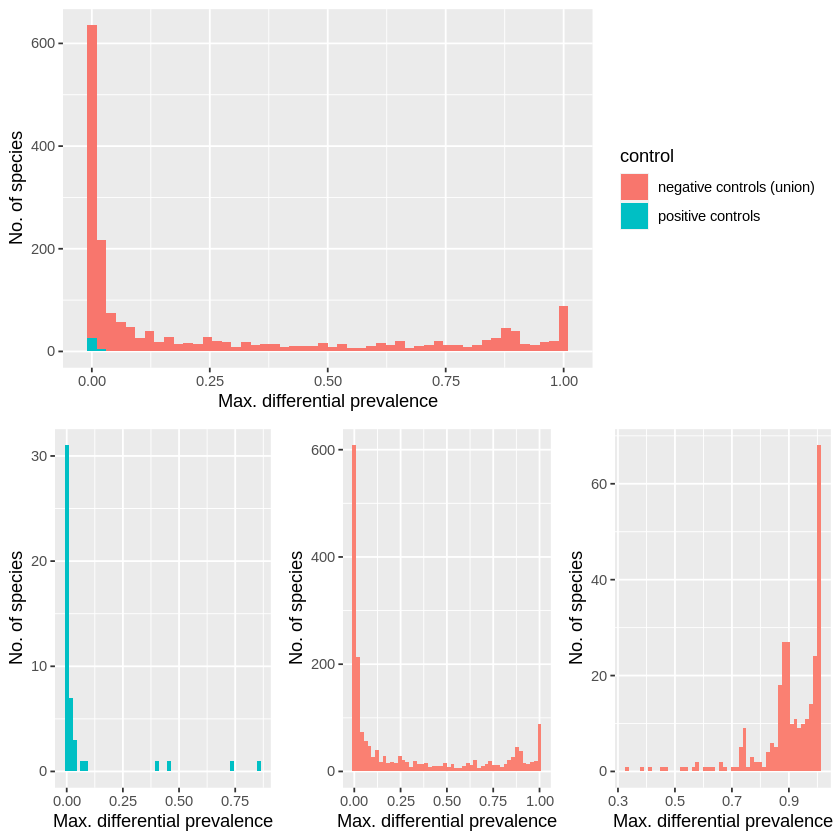

In [11]:
neg_plt <- decon_raw %>% 
    group_by(taxa) %>%
    summarise(max_diff = max(diff)) %>%
    filter(taxa %in% union) %>%
    ggplot(aes(x = max_diff)) +
    geom_histogram(bins = 50, fill = "salmon") +
    labs(x = "Max. differential prevalence", y = "No. of species")

neg_prev <- decon_raw %>% 
    group_by(taxa) %>%
    summarise(max_diff = max(diff)) %>%
    filter(taxa %in% union) %>%
    filter(taxa %in% prevalent_taxa) %>%
    ggplot(aes(x = max_diff)) +
    geom_histogram(bins = 50, fill = "salmon") +
    labs(x = "Max. differential prevalence", y = "No. of species")

pos_plt <- decon_raw %>% 
    group_by(taxa) %>%
    summarise(max_diff = max(diff)) %>%
    filter(taxa %in% pos_control) %>%
    ggplot(aes(x = max_diff)) +
    geom_histogram(bins = 50, fill = "#00bfc4") +
    labs(x = "Max. differential prevalence", y = "No. of species")

combined <- decon_raw %>% 
    group_by(taxa) %>%
    summarise(max_diff = max(diff)) %>%
    mutate(control = case_when(taxa %in% union ~ "negative controls (union)",
                               taxa %in% pos_control ~ "positive controls",
                               TRUE ~ as.character(NA))) %>%
    filter(!is.na(control)) %>%
    ggplot(aes(x = max_diff, fill = control)) +
    geom_histogram(bins = 50) +
    labs(x = "Max. differential prevalence", y = "No. of species")

combined1 <- ggpubr::ggarrange(pos_plt, neg_plt, neg_prev, nrow = 1)
combined2 <- ggpubr::ggarrange(combined, combined1, nrow = 2)
combined2
ggsave(str_glue("results/decontamination/diff_prev_V2/max_prevalence_threshold_combined.read_t{read_threshold}.png"), combined2,
       width = 10, height = 6)

### Parse raw decontamination results

In [12]:
parse_decontamination_results <- function(decontam_res) {
    parsed_res <- decon_raw %>%
        mutate(diff_prev = ifelse(diff > 0.3, T, F)) %>%
        group_by(taxa) %>%
        summarise(n_diff = sum(diff_prev)) 
    
    non_contaminants <- parsed_res %>% filter(n_diff == 0)
    non_contaminants <- non_contaminants$taxa

    contaminants <- parsed_res %>% filter(n_diff > 0)
    contaminants <- contaminants$taxa
    
    return(list(non_contaminants = non_contaminants, contaminants = contaminants))
}


In [13]:
parsed_res <- parse_decontamination_results(decon_raw)
nc <- parsed_res[["non_contaminants"]]
contam <- parsed_res[["contaminants"]]
print(str_glue("No. of non-contamininants = {length(nc)}\nNo. of contaminants = {length(contam)}"))

No. of non-contamininants = 1514
No. of contaminants = 669


#### Save results

In [67]:
fwrite(tibble(non_contaminants = parsed_res[["non_contaminants"]]), str_glue("results/decontamination/diff_prev_V2/noncontam.min_samples{min_samples}.raw.read_t{read_t}.S.n9999.txt"))
fwrite(tibble(contaminants = parsed_res[["contaminants"]]), str_glue("results/decontamination/diff_prev_V2/contam.min_samples{min_samples}.raw.read_t{read_t}.S.n9999.txt"))


### Correlation filter

In [71]:
otu_to_clr <- function(df, meta_filt, human) {
    # Filter data
    df_filt <- retrieve_rows_from_meta(df, meta_filt)
    df_filt2 <- remove_cols(df_filt, c(human, "unclassified"))
    RA_df <- otu_to_RA(df_filt2)
    clr_df <- RA_to_clr(RA_df)
    
    return(clr_df)
}


corr_decontam <- function(df, non_contaminants, contaminants) {
    nc_list <- foreach (non_contaminant_taxon = non_contaminants) %dopar% {
        morsel <- tibble()
        for (contaminant_taxon in contaminants) {
            spearman_test <- cor.test(df[ ,contaminant_taxon], df[, non_contaminant_taxon])
            rho <- spearman_test$estimate
            print(str_glue("{non_contaminant_taxon} has correlation of {rho} with {contaminant_taxon}"))
            morsel <- morsel %>% bind_rows(tibble(non_contaminant_taxon = non_contaminant_taxon, 
                                           contaminant_taxon = contaminant_taxon,
                                           rho = rho))
        }

        return(morsel)
    }

    corr_df <- bind_rows(nc_list)  
    return(corr_df)
}


parse_corr_results <- function(corr_df, nc, corr_t) {
    contaminants <- corr_df %>% 
        filter(rho > corr_t) %>%
        distinct(non_contaminant_taxon) %>%
        rename(contaminants = non_contaminant_taxon)
    
    non_contaminants <- tibble(non_contaminants = nc) %>% 
        filter(!(non_contaminants %in% contaminants$contaminants))
    
    return(list(non_contaminants = non_contaminants, contaminants = contaminants))
}

In [74]:
corr_t <- 0.5

clr_df <- otu_to_clr(df, meta, human)
corr_res <- corr_decontam(clr_df, nc, contam)
corr_parsed <- parse_corr_results(corr_res, nc, corr_t)
corr_nc <- corr_parsed[["non_contaminants"]]
corr_c <- corr_parsed[["contaminants"]]
head(corr_parsed)

non_contaminants
<chr>
Acetobacter aceti
Acetobacter ghanensis
Acetobacter persici
Acidaminococcus intestini
Acidiferrobacter sp. SPIII_3
Acidihalobacter prosperus
Acidiphilium cryptum
Acidiphilium multivorum
Acidipropionibacterium acidipropionici


In [75]:
fwrite(corr_nc, 
       str_glue("results/decontamination/diff_prev_V2/corr.noncontam.min_samples{min_samples}.raw.read_t{read_t}.S.n9999.txt"))
fwrite(corr_c, 
       str_glue("results/decontamination/diff_prev_V2/corr.contam.min_samples{min_samples}.raw.read_t{read_t}.S.n9999.txt"))

### Final results

In [94]:
initial <- ncol(df) - 3
zero_counts <- initial - (ncol(species_prev) - 1)
after_diff <- length(nc)
n_corr_c <- length(corr_c$contaminants)
after_corr <- length(corr_nc$non_contaminants)
print(str_glue("Initial no. of species = {initial}"))
print(str_glue("Species not present in any samples (reads > {read_t}) = {zero_counts}"))
print(str_glue("After differential prevalence filter (min_samples = {min_samples}, prev_t = {prevalence_t}) = {after_diff}"))
print(str_glue("Contaminants for correlation filter (corr_t = {corr_t}) = {n_corr_c}"))
print(str_glue("After correlation filter (corr_t = {corr_t}) = {after_corr}"))

Initial no. of species = 5199
Species not present in any samples (reads > 10) = 3016
After differential prevalence filter (min_samples = 100, prev_t = 0.1) = 1514
Contaminants for correlation filter (corr_t = 0.5) = 16
After correlation filter (corr_t = 0.5) = 1498
